In [1]:
import sys
sys.path.insert(0, "../../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

(-4.0, 0.0)

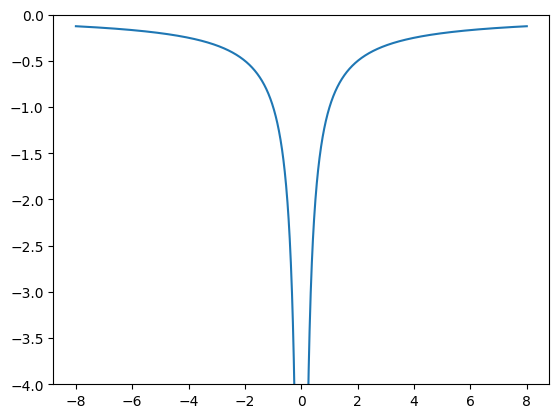

In [4]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    d = jnp.sqrt(jnp.sum(x**2, axis = 1))
    return -1/d


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)

r, line = getLine(0,0, r_max=8)
plt.plot(r, potential(line, None))
plt.ylim(-4, 0)

In [5]:
ansatz = module.wavefunctions.HydrogenicOrbital(2,0,0,1)
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

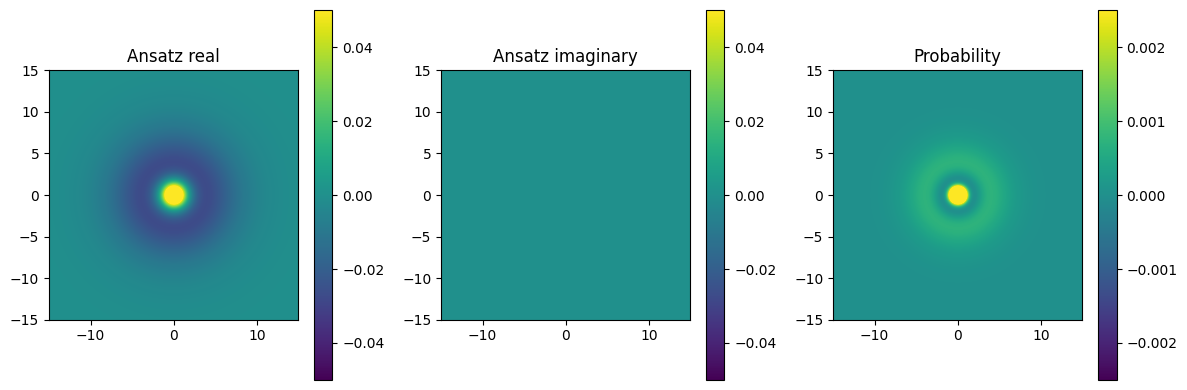

In [213]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

l = 15
ep = 0.05

xs = jnp.linspace(-l, l, num = 1000)
zs = jnp.linspace(-l, l, num = 1000)
xss, zss = jnp.meshgrid(xs, zs)
im = jnp.stack((xss, xss*0, zss), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)

a = axs[0].imshow(res.real, extent = [-l, l, -l, l], vmin = -ep, vmax = ep)
axs[0].set_title("Ansatz real")
plt.colorbar(a, ax=axs[0])

a = axs[1].imshow(res.imag, extent = [-l, l, -l, l], vmin = -ep, vmax = ep)
axs[1].set_title("Ansatz imaginary")
plt.colorbar(a, ax=axs[1])

a = axs[2].imshow(jnp.abs(res)**2, extent = [-l, l, -l, l], vmin = -ep**2, vmax = ep**2)
axs[2].set_title("Probability")
plt.colorbar(a, ax=axs[2])



f.tight_layout()

In [214]:
sampler = module.samplers.MCMCsimple(ansatz, 1)

In [215]:
subsampling = 20

In [216]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

In [217]:
samples, r = get_samples(9000)

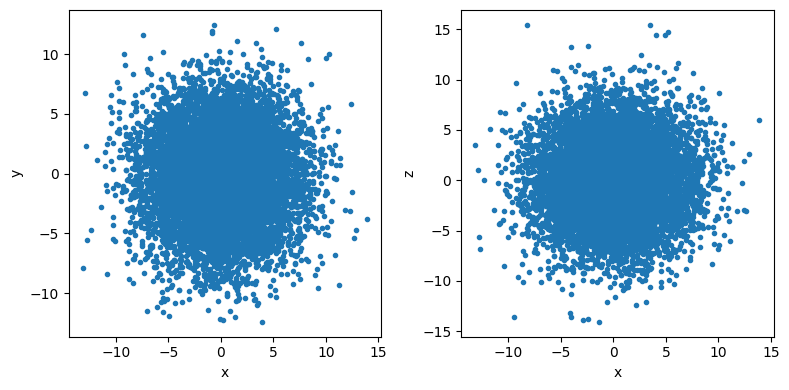

In [218]:
f, axs = plt.subplots(1,2,figsize = (8,4))
axs[0].scatter(samples[:,0], samples[:,1], marker = ".")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].scatter(samples[:,0], samples[:,2], marker = ".")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")

f.tight_layout()

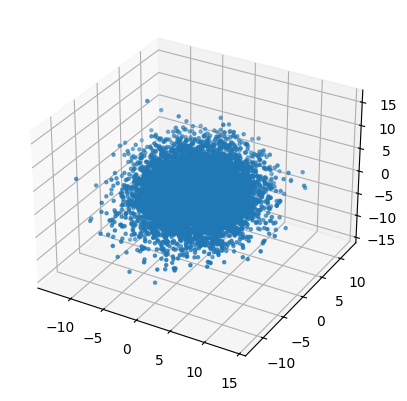

In [219]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:,0],samples[:,1], samples[:,2], marker = ".")

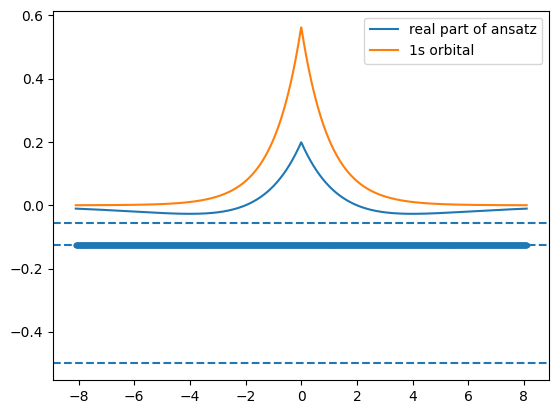

In [220]:
r, line = getLine(0.2,0.3, r_max=8.1)
plt.plot(r, ansatz.calc_psi(param, line).real, label = "real part of ansatz")
plt.plot(r, jnp.exp(-jnp.abs(r))/jnp.sqrt(jnp.pi), label = "1s orbital")

plt.scatter(r, hamiltonian.calc_H_loc(ansatz, param, line).real, marker = ".")
plt.axhline(-0.5, linestyle = "dashed")
plt.axhline(-1/8, linestyle = "dashed")
plt.axhline(-0.5*1/9, linestyle = "dashed")

plt.legend()

In [221]:
## error density

l = 2
xs = jnp.linspace(-l, l, num = 100)
ys = jnp.linspace(-l, l, num = 100)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0 + 1e-2), axis = 2)

res = hamiltonian.calc_H_loc(ansatz, param, im.reshape(-1, 3)).reshape(xss.shape)

Text(0.5, 1.0, 'local energy')

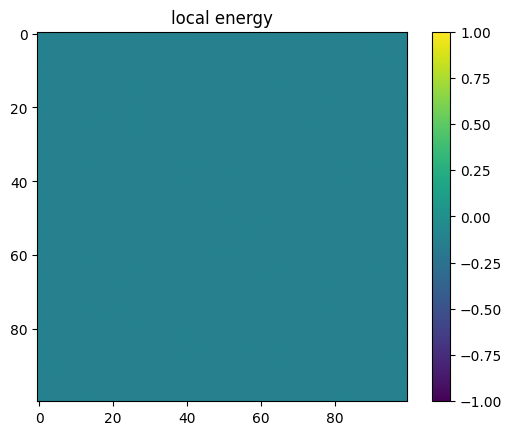

In [222]:
plt.imshow(res.real, vmin = -1, vmax = 1)
plt.colorbar()
plt.title("local energy")

In [223]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples).real
E_f = jnp.mean(H_loc)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
# print("Energy Error:", (jnp.mean(H_loc) + 0.616515)/0.616515)
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.7783800000000001
Expected Energy: -0.125 +/- 1.5406851016308338e-18
Std of Expected Energy: 1.540685101630834e-16


In [180]:
# gut